In [9]:
import torch
import sys
from matplotlib import gridspec
from matplotlib import pyplot as plt
sys.path.append('src')
from score_util_pub import *
from inference import *
import json

### For SDXL-Turbo

In [10]:
model = Generator('sdxl-turbo')

Loading pipeline components...: 100%|██████████| 7/7 [00:29<00:00,  4.15s/it]


In [11]:
seed = 3
prompt = 'a creative chair'
amplification_factor = [1.0]*7

# You can manually select amplification factor for each block 

amplification_factor[0] = 1.075 # amp factor for down 0 block
amplification_factor[1] = 1.15 # amp factor for down 1 block
amplification_factor[2] = 2.6 # amp factor for down 2 block
amplification_factor[3] = 2.8 # amp factor for middle block

# Or you can use the automatically found params
# Please note that the automatically found params are searched for each block 
# and needs to be further scaled to be used in combination.

file_path = f'./results/sdxl-turbo/chair/amp_factors_80.json'
with open(file_path, 'r') as file:
    data = json.load(file)
amplification_factor[0] = 1+(data[0][0]-1)*0.3
amplification_factor[1] = 1+(data[0][1]-1)*0.3
amplification_factor[2] = 1+(data[0][2]-1)*0.2
amplification_factor[3] = 1+(data[0][3]-1)*0.2


In [12]:
orig = model.orig(prompt=prompt, seed=seed)
ours = model.c3(prompt=prompt, seed=seed, replace_mask=amplification_factor)

100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


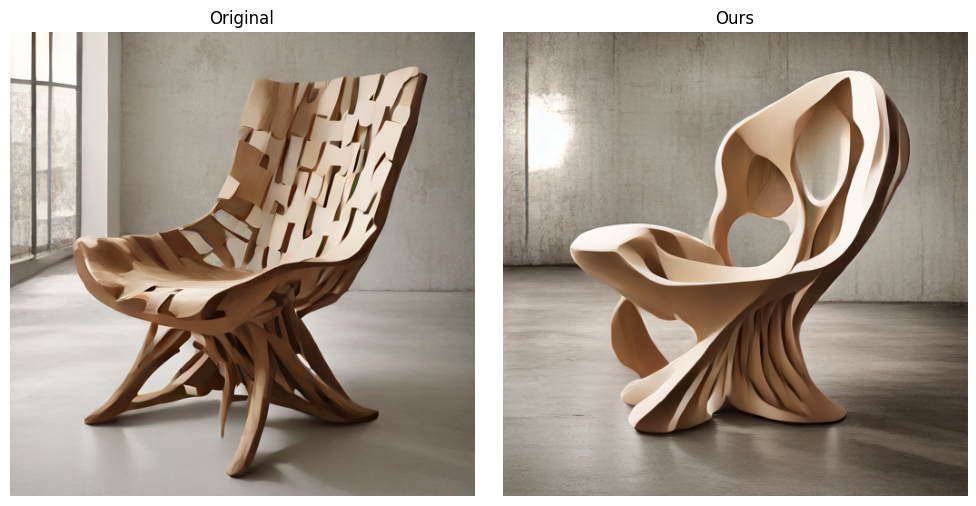

In [13]:
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
fig = plt.figure(figsize=(10, 5))
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax1.imshow(orig)
ax1.axis('off')
ax1.set_title('Original')
ax2.imshow(ours)
ax2.axis('off')
ax2.set_title('Ours')
plt.tight_layout()
plt.show()

100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


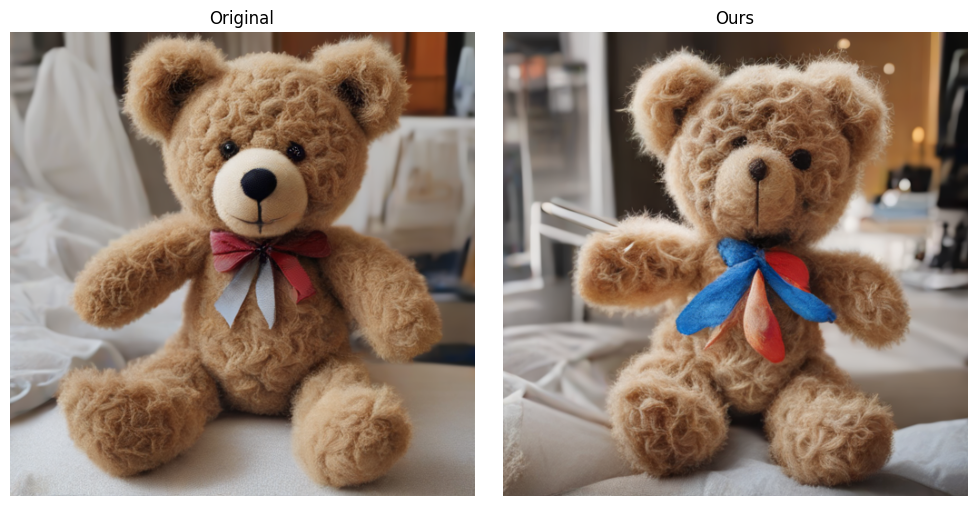

In [19]:
prompt = 'a creative teddy bear'

orig = model.orig(prompt=prompt, seed=seed)
ours = model.c3(prompt=prompt, seed=seed, replace_mask=amplification_factor)


gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
fig = plt.figure(figsize=(10, 5))
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax1.imshow(orig)
ax1.axis('off')
ax1.set_title('Original')
ax2.imshow(ours)
ax2.axis('off')
ax2.set_title('Ours')
plt.tight_layout()
plt.show()



----

## For SDXL-Lightning

In [ ]:
model = Generator('sdxl-light-1')

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 15.56 GiB of which 13.62 MiB is free. Including non-PyTorch memory, this process has 15.54 GiB memory in use. Of the allocated memory 14.84 GiB is allocated by PyTorch, and 571.75 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [3]:
seed = 42
prompt = 'a creative house'
amplification_factor = [1.0]*7

# You can manually select amplification factor for each block 

amplification_factor[0] = 1.1 # amp factor for down 0 block
amplification_factor[1] = 1.3 # amp factor for down 1 block
amplification_factor[2] = 1.6 # amp factor for down 2 block
amplification_factor[3] = 1.8 # amp factor for middle block

# Or you can use the automatically found params
# Please note that the automatically found params are searched for each block 
# and needs to be further scaled to be used in combination.

file_path = f'./results/sdxl-light-1/house/amp_factors_80.json'
with open(file_path, 'r') as file:
    data = json.load(file)
amplification_factor[0] = 1+(data[0][0]-1)*0.2
amplification_factor[1] = 1+(data[0][1]-1)*0.2
amplification_factor[2] = 1+(data[0][2]-1)*0.1
amplification_factor[3] = 1+(data[0][3]-1)*0.1


In [4]:
orig = model.orig(prompt=prompt, seed=seed)
ours = model.c3(prompt=prompt, seed=seed, replace_mask=amplification_factor, cutoff=[10.0,5.0,5.0,5.0,1.0,1.0,1.0])

100%|██████████| 1/1 [00:00<00:00,  6.19it/s]


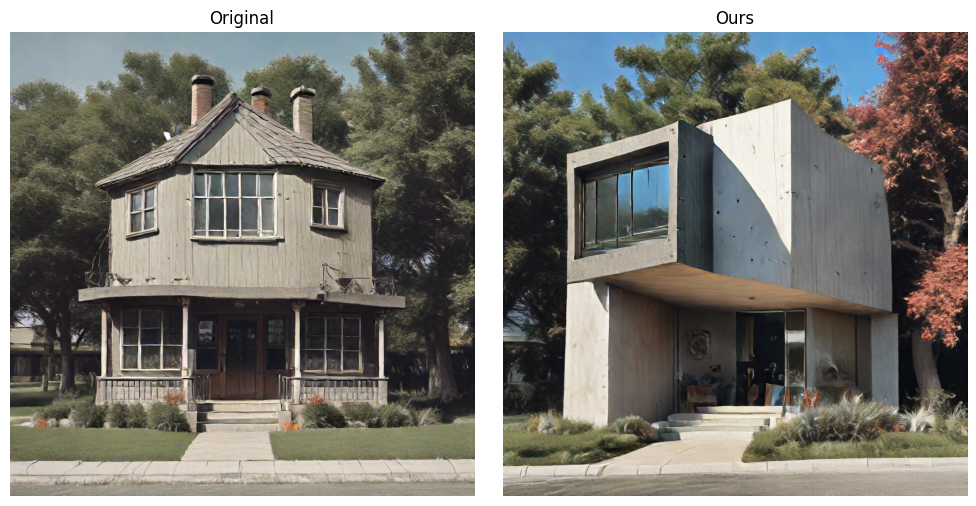

In [5]:
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
fig = plt.figure(figsize=(10, 5))
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax1.imshow(orig)
ax1.axis('off')
ax1.set_title('Original')
ax2.imshow(ours)
ax2.axis('off')
ax2.set_title('Ours')
plt.tight_layout()
plt.show()